In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorly as tl
import tlviz

### Functional Analysis of NBA Player Career Trajectory 

$$ y(t) = X\Phi(t) + \epsilon $$
$$ \epsilon \sim \mathcal{N}(0, \Sigma) $$
where $\Phi(t)$ is a functional. Here, we let $X$ be fixed set of covariates (initially)

In [26]:
data = pd.read_csv("data/player_data.csv").query(" age <= 38 ")

In [27]:
data.head()

,year,season,id,minutes,fg2m,fg2a,fg3a,fg3m,ftm,fta,...,position,team,age,obpm,dbpm,bpm,games,total_seasons,median_minutes_per_game,max_minutes
0,1997,1996-97,2,1439.778333,90,191,188,73,127,151,...,SG,LAL,35,0.6,0.4,1.0,79,1,18.225042,1439.778333
1,1997,1996-97,3,1170.195000,106,228,47,17,63,84,...,PF,DET,30,-1.0,0.3,-0.6,65,7,21.958214,1868.101667
2,1998,1997-98,3,741.726667,50,113,4,0,41,57,...,PF,DET,31,-2.6,1.5,-1.1,40,7,21.958214,1868.101667
3,1999,1998-99,3,1380.178333,148,341,18,3,184,235,...,PF,ATL,32,-0.3,1.7,1.5,50,7,21.958214,1868.101667
4,2000,1999-00,3,922.245000,74,163,4,0,55,71,...,PF,VAN,33,-1.9,0.3,-1.7,42,7,21.958214,1868.101667


In [28]:
def process_data(df, output_metric, exposure, model, input_metrics):

    agg_dict = {input_metric:"max" for input_metric in input_metrics}
    df = df.sort_values(by=["id","year"])
    df["ft_pct"] = df["ftm"] / df["fta"]
    df["three_pct"] = df["fg3m"] / df["fg3a"]
    df["two_pct"] = df["fg2m"] / df["fg2a"]
    X = df[input_metrics + ["id"]].groupby("id").agg(agg_dict).reset_index()[input_metrics]
    metric_df = df[[output_metric, "id", "age"]]
    exposure_df = df[["id", "age", exposure]]
    games_df = df[["id", "age", "games"]]
    metric_df  = metric_df.pivot(columns="age",values=output_metric,index="id")
    if model == "poisson":
        offset = np.log(exposure_df.pivot(columns="age", values=exposure,index="id").to_numpy()) + np.log(games_df.pivot(columns="age", values = "games", index = "id").to_numpy())
        return offset, metric_df.to_numpy(), X
    elif model == "binomial":
        trials = exposure_df.pivot(columns="age", index="id", values=exposure).to_numpy()
        return trials, metric_df.to_numpy(), X
    elif model == "gaussian":
        variance_scale = np.sqrt(exposure_df.pivot(columns="age", index="id", values=exposure).to_numpy())
        return variance_scale, metric_df.to_numpy(), X
    return ValueError


In [7]:
exposure, Y, X = process_data(data, "obpm", "median_minutes_per_game", "gaussian", ["position_group"])

In [8]:
fixed_eff_matrix = np.insert(pd.get_dummies(X[["position_group"]], drop_first=True,dtype=int).to_numpy(), 0 , 1, axis = 1)

### Build Model

Will use a HSGP as a prior on the weights of the basis function (3 x 27)



In [8]:
mask = np.isfinite(exposure)


In [4]:
basis = np.arange(18,45)
radial_basis_function = np.exp(-1/50*np.square(np.subtract.outer(basis,basis)))

In [45]:
with pm.Model() as fda_model:
    
    exposure_scale = pm.MutableData("exposure_scale", exposure[mask].flatten())
    radial_basis = pm.MutableData("radial_basis", radial_basis_function)
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.5)

    gp = pm.gp.HSGP(m=[5], c=4.0, cov_func=cov_func)
    

    basis_weight_1 = gp.prior("basis_weights_1",X=basis[:,None])
    basis_weight_2 = gp.prior("basis_weights_2",X=basis[:,None])
    basis_weight_3 = gp.prior("basis_weights_3",X=basis[:,None])
    basis_weights = pm.Deterministic("basis_weights", pm.math.stack([basis_weight_1, basis_weight_2, basis_weight_3], axis = 0))
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    
    mu = pm.Deterministic("mu",pm.math.dot(pm.math.dot(fixed_effects, basis_weights), radial_basis)) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu[mask]), sigma = sd / exposure_scale, observed=Y[mask].flatten())

with fda_model:
    trace = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights_1_hsgp_coeffs_, basis_weights_2_hsgp_coeffs_, basis_weights_3_hsgp_coeffs_, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1117 seconds.


/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='basis_weights\n0, 1'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 2'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 3'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 4'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 5'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 6'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 7'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='basis_weights\n0, 0', ylabel='basis_weights\n0, 8'>,
        <Axes: xlabel='basis_weights\n0, 1'>,
   

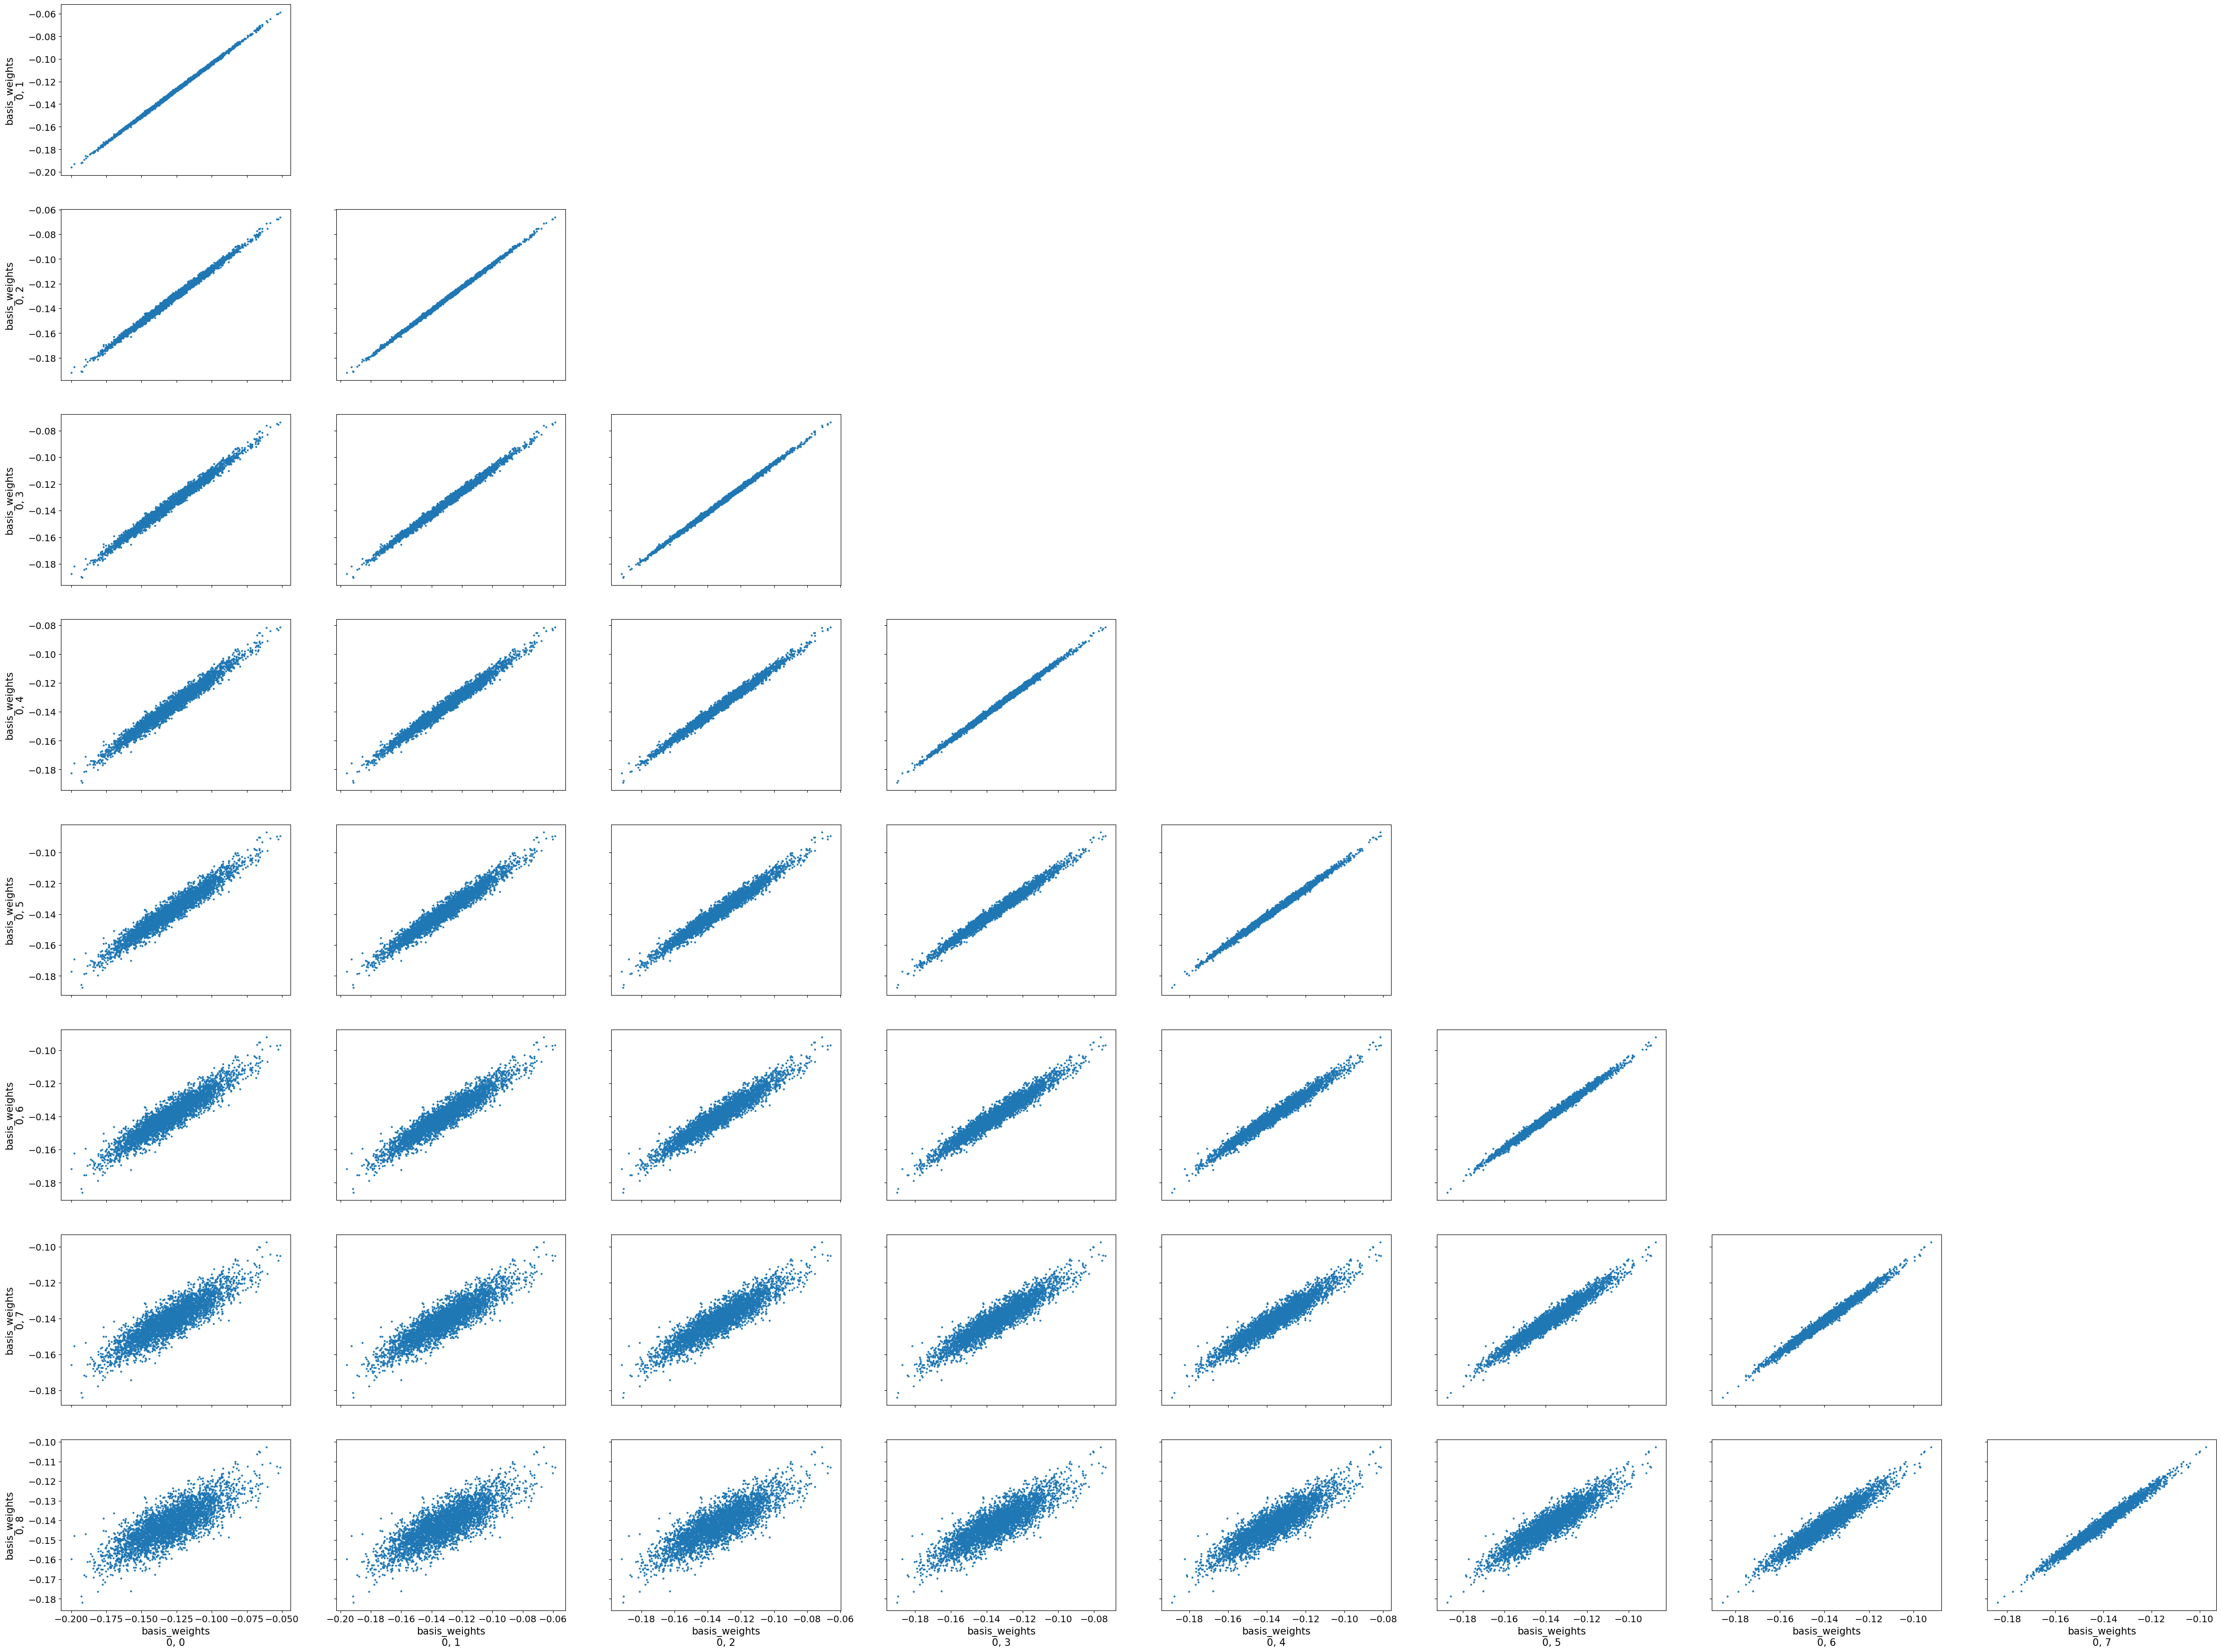

In [32]:
az.plot_pair(trace, var_names="basis_weights")

In [46]:
az.summary(trace.posterior.basis_weights)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"basis_weights[0, 0]",-0.288,0.046,-0.371,-0.202,0.001,0.000,4477.0,3216.0,1.0
"basis_weights[0, 1]",-0.258,0.038,-0.331,-0.189,0.001,0.000,4482.0,3206.0,1.0
"basis_weights[0, 2]",-0.229,0.031,-0.285,-0.168,0.000,0.000,4468.0,3131.0,1.0
"basis_weights[0, 3]",-0.201,0.025,-0.244,-0.151,0.000,0.000,4422.0,3040.0,1.0
"basis_weights[0, 4]",-0.174,0.020,-0.210,-0.137,0.000,0.000,4393.0,2845.0,1.0
...,...,...,...,...,...,...,...,...,...
"basis_weights[2, 22]",0.067,0.051,-0.027,0.163,0.001,0.001,4338.0,3550.0,1.0
"basis_weights[2, 23]",0.051,0.060,-0.061,0.163,0.001,0.001,4375.0,3486.0,1.0
"basis_weights[2, 24]",0.035,0.069,-0.088,0.168,0.001,0.001,4401.0,3548.0,1.0
"basis_weights[2, 25]",0.020,0.078,-0.123,0.167,0.001,0.001,4425.0,3452.0,1.0


# Results

In [47]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()

In [48]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [49]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


In [37]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Age')

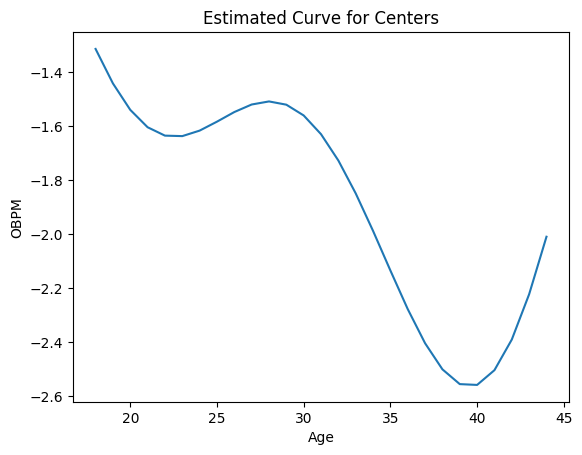

In [50]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

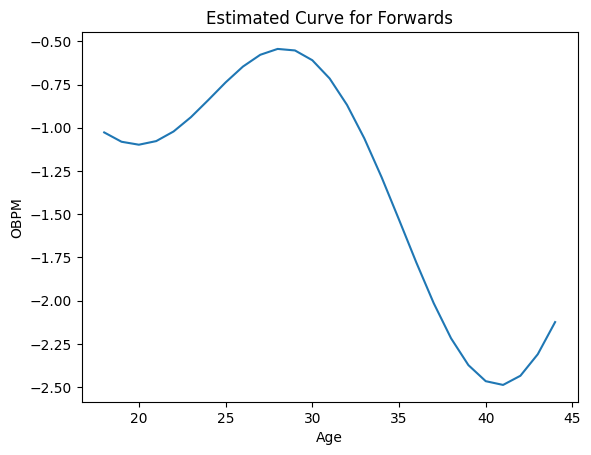

In [51]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_1_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Forwards")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

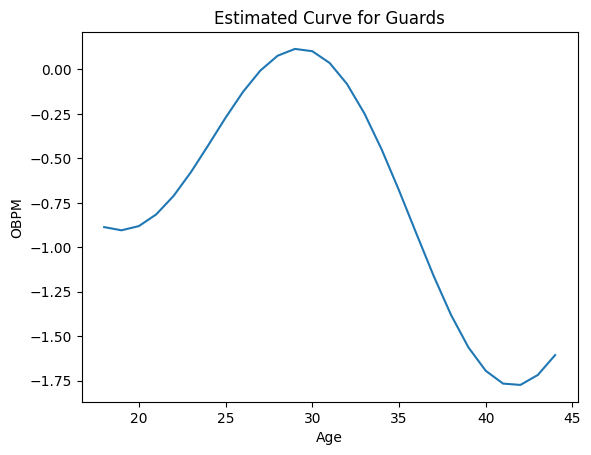

In [52]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_2_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Guards")
plt.ylabel("OBPM")
plt.xlabel("Age")

In [44]:
position_2_weights

array([0.089, 0.092, 0.095, 0.098, 0.101, 0.104, 0.107, 0.11 , 0.113,
       0.116, 0.119, 0.121, 0.124, 0.126, 0.128, 0.131, 0.133, 0.135,
       0.136, 0.138, 0.14 , 0.141, 0.142, 0.143, 0.144, 0.144, 0.144])

# Model 
Now we will just approximate the actual latent functional with a GP 

In [53]:
with pm.Model() as fda_model:
    
    exposure_scale = pm.MutableData("exposure_scale", exposure[mask].flatten())
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.5)

    gp = pm.gp.HSGP(m=[5], c=4.0, cov_func=cov_func)
    

    basis_weight_1 = gp.prior("basis_weights_1",X=basis[:,None])
    basis_weight_2 = gp.prior("basis_weights_2",X=basis[:,None])
    basis_weight_3 = gp.prior("basis_weights_3",X=basis[:,None])
    basis_weights = pm.Deterministic("basis_weights", pm.math.stack([basis_weight_1, basis_weight_2, basis_weight_3], axis = 0))
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    
    mu = pm.Deterministic("mu", pm.math.dot(fixed_effects, basis_weights)) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu[mask]), sigma = sd / exposure_scale, observed=Y[mask].flatten())

with fda_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights_1_hsgp_coeffs_, basis_weights_2_hsgp_coeffs_, basis_weights_3_hsgp_coeffs_, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.


# Results

In [54]:
az.summary(trace.posterior.basis_weights)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"basis_weights[0, 0]",-1.247,0.125,-1.477,-1.013,0.002,0.001,4382.0,3390.0,1.0
"basis_weights[0, 1]",-1.252,0.116,-1.463,-1.033,0.002,0.001,4501.0,3547.0,1.0
"basis_weights[0, 2]",-1.253,0.108,-1.445,-1.045,0.002,0.001,4679.0,3481.0,1.0
"basis_weights[0, 3]",-1.252,0.100,-1.440,-1.068,0.001,0.001,4938.0,3567.0,1.0
"basis_weights[0, 4]",-1.248,0.094,-1.421,-1.069,0.001,0.001,5283.0,3405.0,1.0
...,...,...,...,...,...,...,...,...,...
"basis_weights[2, 22]",0.374,0.165,0.068,0.689,0.002,0.002,4390.0,3363.0,1.0
"basis_weights[2, 23]",0.252,0.176,-0.080,0.578,0.003,0.002,4329.0,3364.0,1.0
"basis_weights[2, 24]",0.128,0.186,-0.206,0.490,0.003,0.002,4265.0,3306.0,1.0
"basis_weights[2, 25]",0.007,0.197,-0.351,0.383,0.003,0.003,4227.0,3168.0,1.0


In [55]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()


In [56]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [57]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


Text(0.5, 0, 'Age')

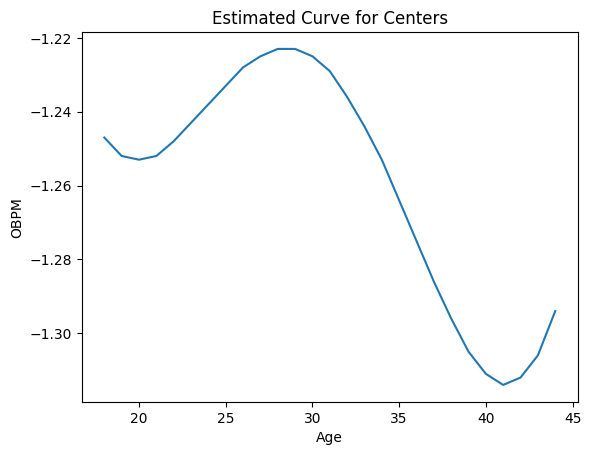

In [59]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis] )
plt.title("Estimated Curve for Centers")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

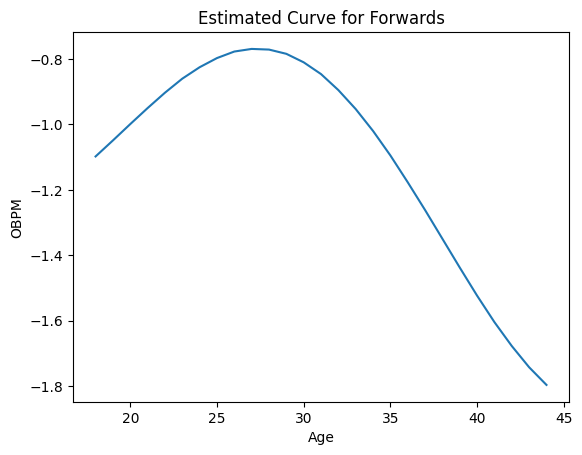

In [61]:
plt.plot(range(18,45), position_1_weights[:,np.newaxis] + position_0_weights[:, np.newaxis] )
plt.title("Estimated Curve for Forwards")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

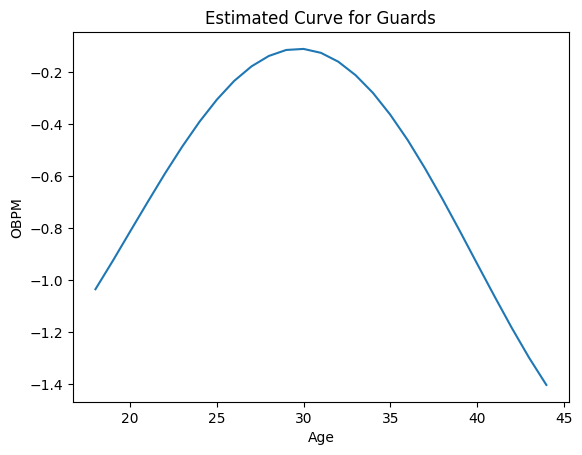

In [62]:
plt.plot(range(18,45), position_2_weights[:,np.newaxis] + position_0_weights[:, np.newaxis] )
plt.title("Estimated Curve for Guards")
plt.ylabel("OBPM")
plt.xlabel("Age")

### Fit All Metrics Independently 
We are going to fit all metrics independently with GP prior on the functional. There will be independent functionals for each metric.

In [29]:
metric_output = (["gaussian"] * 2) + (["poisson"] * 6) + (["binomial"] * 3)
metrics = ["obpm","dbpm","blk","stl","ast","dreb","oreb","tov","ftm","fg2m","fg3m"]
exposure_list = (["median_minutes_per_game"] * 8) + ["fta","fg2a","fg3a"]
covariate_size = 3
data_set = []

for output,metric,exposure_val in zip(metric_output, metrics, exposure_list):
    exposure, Y, _ = process_data(data, metric, exposure_val, output, ["position_group"])
    data_dict = {"metric":metric, "output": output, "exposure_data": exposure, "output_data": Y, "mask": np.isfinite(exposure)}
    data_set.append(data_dict)

(2328, 21)

In [11]:
with pm.Model() as fda_model:
    
    
    cov_func = pm.gp.cov.ExpQuad(1, ls=1)

    gp = pm.gp.HSGP(m=[5], c=4.0, cov_func=cov_func)
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    for data_entity in data_set:
        output = data_entity["output"]
        metric = data_entity["metric"]
        mask = data_entity["mask"]
        exposure_data = data_entity["exposure_data"]
        output_data = data_entity["output_data"]
        exposure = pm.MutableData(f"exposure_{metric}", exposure_data[mask].flatten())
        basis_weights =  pm.math.stack([gp.prior(f"basis_weights_{metric}_{i}", X = basis[:, None]) for i in range(covariate_size)], axis = 0)
        mu =  pm.math.dot(fixed_effects, basis_weights) ### get mu

        if output == "gaussian":
            sd = pm.Exponential(f"sigma_{metric}", 1.0)
            ## likelihood
            y = pm.Normal(f"likelihood_{metric}", mu = pm.math.flatten(mu[mask]), sigma = sd / exposure, observed=output_data[mask].flatten())
        
        elif output == "poisson":
            y = pm.Poisson(f"likelihood_{metric}", mu = pm.math.exp(pm.math.flatten(mu[mask]) + exposure), observed = output_data[mask].flatten())
        
        elif output == "binomial":
            y = pm.Binomial(f"likelihod_{metric}", logit_p = pm.math.flatten(mu[mask]), n = exposure, observed=output_data[mask].flatten())
    
    # gv = pm.model_graph.model_to_graphviz()
    # gv.format = 'png'
    # gv.render(filename='model_graph')

with fda_model:
    print("fitting model")
    trace = pm.sample()

az.to_netcdf(trace, "data/uncorrelated_metrics.ncdf")

fitting model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights_obpm_0_hsgp_coeffs_, basis_weights_obpm_1_hsgp_coeffs_, basis_weights_obpm_2_hsgp_coeffs_, sigma_obpm, basis_weights_dbpm_0_hsgp_coeffs_, basis_weights_dbpm_1_hsgp_coeffs_, basis_weights_dbpm_2_hsgp_coeffs_, sigma_dbpm, basis_weights_blk_0_hsgp_coeffs_, basis_weights_blk_1_hsgp_coeffs_, basis_weights_blk_2_hsgp_coeffs_, basis_weights_stl_0_hsgp_coeffs_, basis_weights_stl_1_hsgp_coeffs_, basis_weights_stl_2_hsgp_coeffs_, basis_weights_ast_0_hsgp_coeffs_, basis_weights_ast_1_hsgp_coeffs_, basis_weights_ast_2_hsgp_coeffs_, basis_weights_dreb_0_hsgp_coeffs_, basis_weights_dreb_1_hsgp_coeffs_, basis_weights_dreb_2_hsgp_coeffs_, basis_weights_oreb_0_hsgp_coeffs_, basis_weights_oreb_1_hsgp_coeffs_, basis_weights_oreb_2_hsgp_coeffs_, basis_weights_tov_0_hsgp_coeffs_, basis_weights_tov_1_hsgp_coeffs_, basis_weights_tov_2_hsgp_coeffs_, basis_weights_ftm_0_hs

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35902 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


'data/uncorrelated_metrics.ncdf'

In [15]:
az.summary(trace, var_names = [f"basis_weights_{metric}_{i}" for i in range(covariate_size) for metric in metrics])

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,basis_weights_obpm_0[0],-1.473,0.149,-1.749,-1.193,0.002,0.001,6596.0,3663.0,1.0
1,basis_weights_obpm_0[1],-1.462,0.137,-1.727,-1.214,0.002,0.001,6448.0,3728.0,1.0
2,basis_weights_obpm_0[2],-1.448,0.125,-1.687,-1.212,0.002,0.001,6266.0,3798.0,1.0
3,basis_weights_obpm_0[3],-1.432,0.115,-1.653,-1.218,0.001,0.001,6057.0,3918.0,1.0
4,basis_weights_obpm_0[4],-1.415,0.106,-1.614,-1.214,0.001,0.001,5839.0,3873.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,basis_weights_fg3m_2[22],-0.005,0.090,-0.172,0.160,0.002,0.001,2901.0,2921.0,1.0
887,basis_weights_fg3m_2[23],-0.030,0.101,-0.212,0.160,0.002,0.001,2938.0,2775.0,1.0
888,basis_weights_fg3m_2[24],-0.054,0.111,-0.249,0.162,0.002,0.002,2981.0,2789.0,1.0
889,basis_weights_fg3m_2[25],-0.077,0.122,-0.288,0.163,0.002,0.002,3031.0,2657.0,1.0


In [12]:
recovered_basis_weights = [az.summary(trace, var_names = [f"basis_weights_{metric}_{i}" for i in range(covariate_size)])[["mean"]].to_numpy().reshape((3,27)) for metric in metrics]

    

In [13]:
metric_weight_tensor = np.stack(recovered_basis_weights)

In [26]:
corr_mats = [np.corrcoef(metric_weight_tensor[:,i,:]) for i in range(covariate_size)]

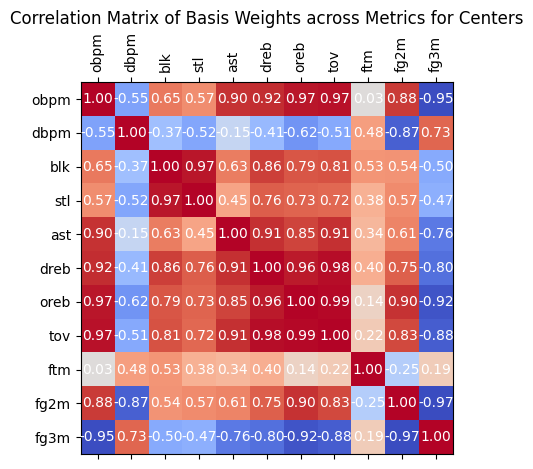

Text(0.5, 1.0, 'Eigenvalues of Correlation Matrix (Centers)')

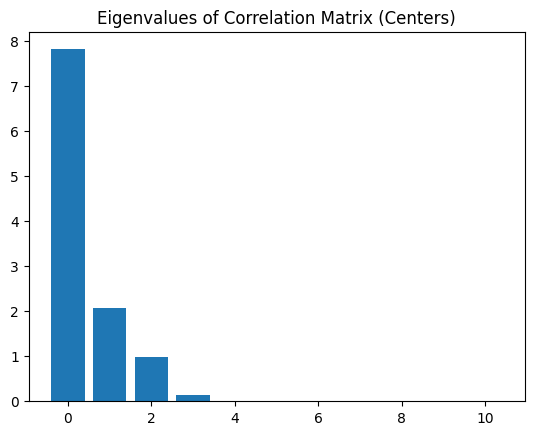

In [29]:
corr_mat = pd.DataFrame(metric_weight_tensor[:,0,:].T, columns=metrics).corr()
eig_vals = np.linalg.eigvals(corr_mat)
plt.matshow(corr_mat, cmap = "coolwarm")
for i in range(len(metrics)):
    for j in range(len(metrics)):
        text = plt.text(j, i, '{:.2f}'.format(corr_mat.iloc[i, j]),
                       ha='center', va='center', color='w', fontsize=10)
plt.xticks(ticks = range(len(metrics)), labels = metrics, rotation = 90)
plt.yticks(ticks = range(len(metrics)), labels = metrics, rotation = 0)
plt.title("Correlation Matrix of Basis Weights across Metrics for Centers")
plt.show()

plt.bar(x = range(11), height = eig_vals)
plt.title("Eigenvalues of Correlation Matrix (Centers)")

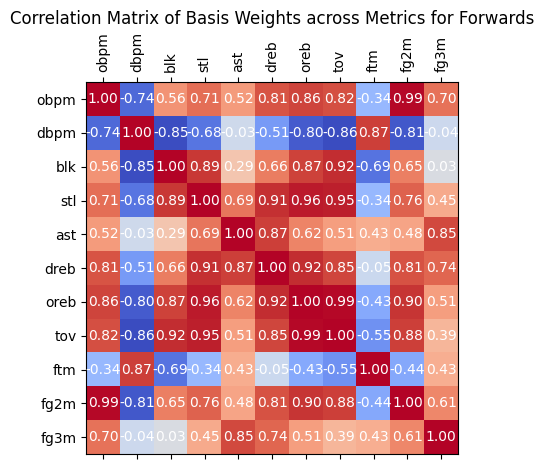

Text(0.5, 1.0, 'Eigenvalues of Correlation Matrix (Forwards)')

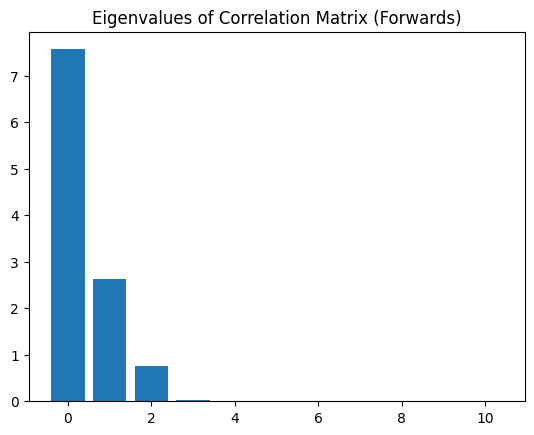

In [31]:
corr_mat = pd.DataFrame(metric_weight_tensor[:,0,:].T + metric_weight_tensor[:,1,:].T, columns=metrics).corr()
eig_vals = np.linalg.eigvals(corr_mat)
plt.matshow(corr_mat, cmap = "coolwarm")
for i in range(len(metrics)):
    for j in range(len(metrics)):
        text = plt.text(j, i, '{:.2f}'.format(corr_mat.iloc[i, j]),
                       ha='center', va='center', color='w', fontsize=10)
plt.xticks(ticks = range(len(metrics)), labels = metrics, rotation = 90)
plt.yticks(ticks = range(len(metrics)), labels = metrics, rotation = 0)
plt.title("Correlation Matrix of Basis Weights across Metrics for Forwards")
plt.show()

plt.bar(x = range(11), height = eig_vals)
plt.title("Eigenvalues of Correlation Matrix (Forwards)")

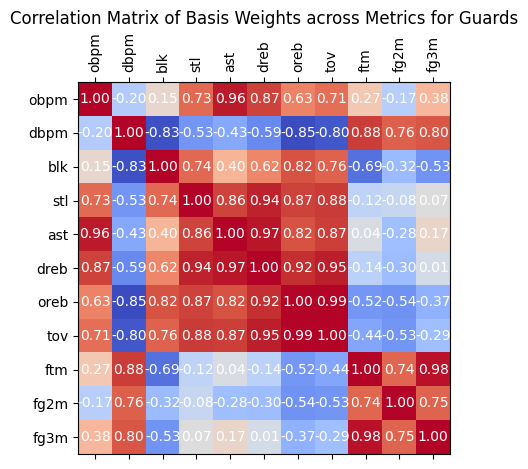

Text(0.5, 1.0, 'Eigenvalues of Correlation Matrix (Guards)')

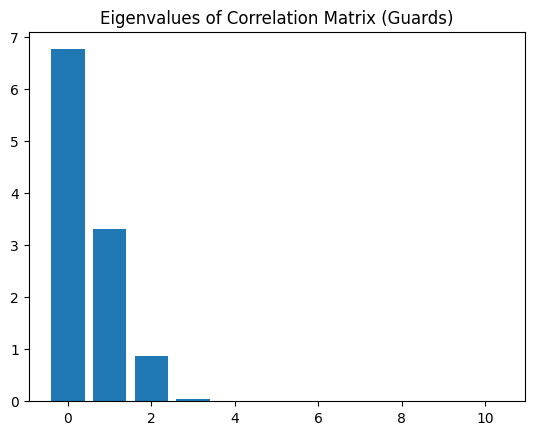

In [32]:
corr_mat = pd.DataFrame(metric_weight_tensor[:,0,:].T + metric_weight_tensor[:,2,:].T, columns=metrics).corr()
eig_vals = np.linalg.eigvals(corr_mat)
plt.matshow(corr_mat, cmap = "coolwarm")
for i in range(len(metrics)):
    for j in range(len(metrics)):
        text = plt.text(j, i, '{:.2f}'.format(corr_mat.iloc[i, j]),
                       ha='center', va='center', color='w', fontsize=10)
plt.xticks(ticks = range(len(metrics)), labels = metrics, rotation = 90)
plt.yticks(ticks = range(len(metrics)), labels = metrics, rotation = 0)
plt.title("Correlation Matrix of Basis Weights across Metrics for Guards")
plt.show()

plt.bar(x = range(11), height = eig_vals)
plt.title("Eigenvalues of Correlation Matrix (Guards)")

### Use a Covariate Space which is Continuous
The idea is to perform PCA on matrix of career averages of desired metrics, and use those values as my X matrix

In [31]:
agg_dict = {"obpm":"mean", "dbpm":"mean", "bpm":"mean", 
            "minutes":"sum", "dreb": "sum", "fta":"sum", "ftm":"sum", "oreb":"sum",
            "ast":"sum", "tov":"sum", "fg2m":"sum", "fg3m":"sum", "fg3a":"sum", "fg2a":"sum", "blk":"sum", "stl":"sum"}
data["total_minutes"] = data["median_minutes_per_game"] * data["games"]

In [32]:
agged_data = data.groupby("id").agg(agg_dict).reset_index()

In [33]:
agged_data["ft_pct"] = agged_data["ftm"] / agged_data["fta"]
agged_data["fg2_pct"] = agged_data["fg2m"] / agged_data["fg2a"]
agged_data["fg3_pct"] = agged_data["fg3m"] / agged_data["fg3a"]

In [34]:
agged_data["dreb_rate"] = agged_data["dreb"] / agged_data["minutes"]
agged_data["oreb_rate"] = agged_data["oreb"] / agged_data["minutes"]
agged_data["ast_rate"] = agged_data["ast"] / agged_data["minutes"]
agged_data["tov_rate"] = agged_data["tov"] / agged_data["minutes"]
agged_data["blk_rate"] = agged_data["blk"] / agged_data["minutes"]
agged_data["stl_rate"] = agged_data["stl"] / agged_data["minutes"]

In [35]:
agged_data.fillna(0, inplace=True)

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [37]:
latent_metrics = ["obpm","dbpm","minutes","ft_pct","fg2_pct","fg3_pct","dreb_rate","oreb_rate","ast_rate","tov_rate","blk_rate","stl_rate"]

In [38]:
X = StandardScaler().fit_transform(agged_data[latent_metrics])

In [19]:
X.min()

-15.247160273858894

In [39]:
pca_x = PCA(whiten=True).fit(X)

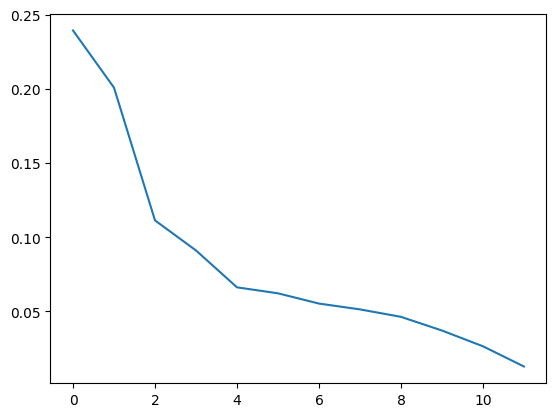

In [40]:
plt.plot(pca_x.explained_variance_ratio_)

use first 4 / 5 (elbow method)

In [41]:
X_pca = pca_x.transform(X)

In [42]:
X_pca.max(axis=0)

array([ 8.61602059,  8.31605406, 11.65222916, 12.93998027, 11.49134136,
       14.88350155, 11.83896484,  9.85196526,  7.55545391, 11.6794602 ,
       18.59336499,  8.42398243])

In [43]:
covariate_X = MinMaxScaler().fit_transform(X_pca[:, 0:3])

In [44]:
covariate_size = covariate_X.shape[1]

In [50]:
data.age.max()

38

### Fit Model

In [51]:
with pm.Model() as fda_model:
    basis = np.arange(18,38)
    fixed_effects = pm.MutableData("X", covariate_X) ### X data (latent space)
    for data_entity in data_set:
        output = data_entity["output"]
        metric = data_entity["metric"]
        mask = data_entity["mask"]
        exposure_data = data_entity["exposure_data"]
        output_data = data_entity["output_data"]
        exposure = pm.MutableData(f"exposure_{metric}", exposure_data[mask].flatten())
        cov_func = pm.gp.cov.ExpQuad(1, ls=1)
        gp = pm.gp.HSGP(m=[10], c=4.0, cov_func=cov_func)
        basis_weights =  pm.math.stack([gp.prior(f"basis_weights_{metric}_{i}", X = basis[:, None]) for i in range(covariate_size)], axis = 0)
        mu =  pm.math.dot(fixed_effects, basis_weights) ### get mu
        intercept = pm.Normal(f"intercept_{metric}", 0, 5, shape = (1,))

        if output == "gaussian":
            sd = pm.Exponential(f"sigma_{metric}", 1.0)
            ## likelihood
            y = pm.Normal(f"likelihood_{metric}", mu = pm.math.flatten(mu[mask]) + intercept, sigma = sd / exposure, observed=output_data[mask].flatten())
        
        elif output == "poisson":
            y = pm.Poisson(f"likelihood_{metric}", mu = pm.math.exp(pm.math.flatten(mu[mask]) + intercept + exposure), observed = output_data[mask].flatten())
        
        elif output == "binomial":
            y = pm.Binomial(f"likelihod_{metric}", logit_p = pm.math.flatten(mu[mask]) + intercept, n = exposure, observed=output_data[mask].flatten())
    
    # gv = pm.model_graph.model_to_graphviz()
    # gv.format = 'png'
    # gv.render(filename='model_graph')

with fda_model:
    print("fitting model")
    trace = pm.sample()

az.to_netcdf(trace, "data/uncorrelated_metrics_pca.ncdf")

fitting model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


IndexError: boolean index did not match indexed array along dimension 1; dimension is 20 but corresponding boolean dimension is 21
Apply node that caused the error: AdvancedSubtensor(Dot22.0, [[False Fa ... se False]])
Toposort index: 94
Inputs types: [TensorType(float64, shape=(None, 20)), TensorType(bool, shape=(2328, 21))]
Inputs shapes: [(2328, 20), (2328, 21)]
Inputs strides: [(160, 8), (21, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Composite{...}(ExpandDims{axis=0}.0, exposure_obpm, likelihood_obpm{[ 0.6 -1. ... -3.1  0. ]}, AdvancedSubtensor.0, ExpandDims{axis=0}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
    result = self._run_cell(
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
    result = runner(coro)
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/h18vf05j4jsgmvd2j5k8nl840000gn/T/ipykernel_1602/1344640297.py", line 20, in <module>
    y = pm.Normal(f"likelihood_{metric}", mu = pm.math.flatten(mu[mask]) + intercept, sigma = sd / exposure, observed=output_data[mask].flatten())

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [17]:
trace = az.from_netcdf("data/uncorrelated_metrics_pca.ncdf")

<Axes: xlabel='sigma_obpm', ylabel='sigma_dbpm'>

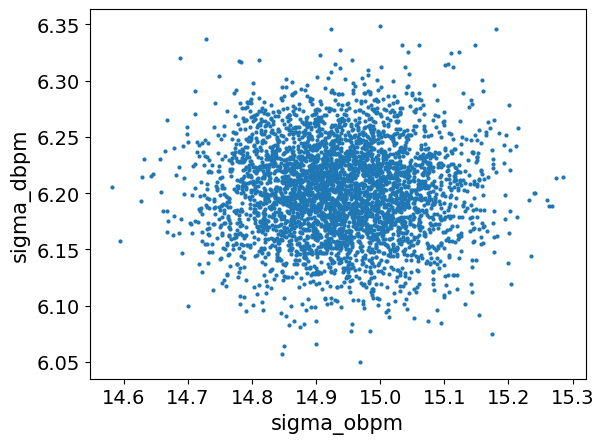

In [18]:
az.plot_pair(trace, var_names=["sigma_obpm","sigma_dbpm"])

In [21]:
recovered_basis_weights = [az.summary(trace, var_names = [f"basis_weights_{metric}_{i}" for i in range(covariate_size)])[["mean"]].to_numpy().reshape((3,27)) for metric in metrics]

    

In [22]:
metric_weight_tensor = np.stack(recovered_basis_weights)

In [23]:
metric_weight_tensor.shape

(11, 3, 27)

In [65]:
from tensorly.decomposition import parafac

In [75]:
cp_tensor = parafac(metric_weight_tensor, 3, init="random", random_state=0)

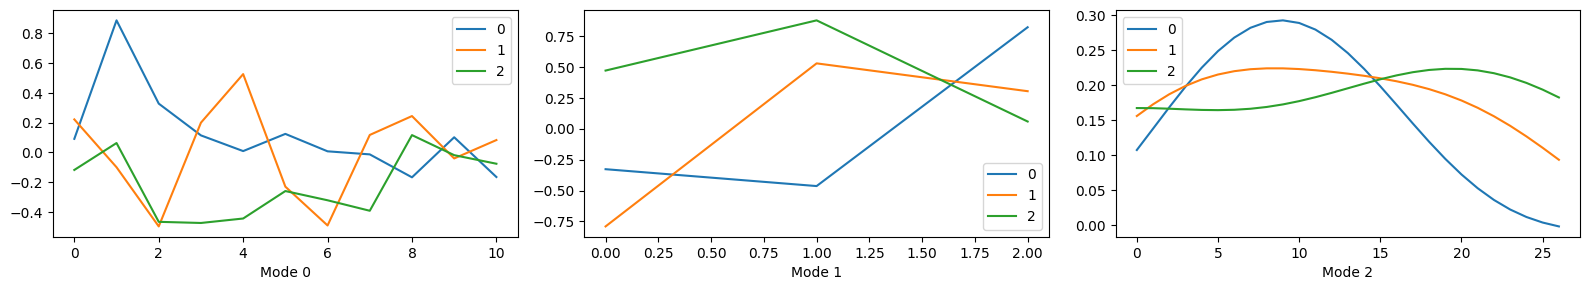

In [76]:
fig, ax = tlviz.visualisation.components_plot(cp_tensor)
plt.show()

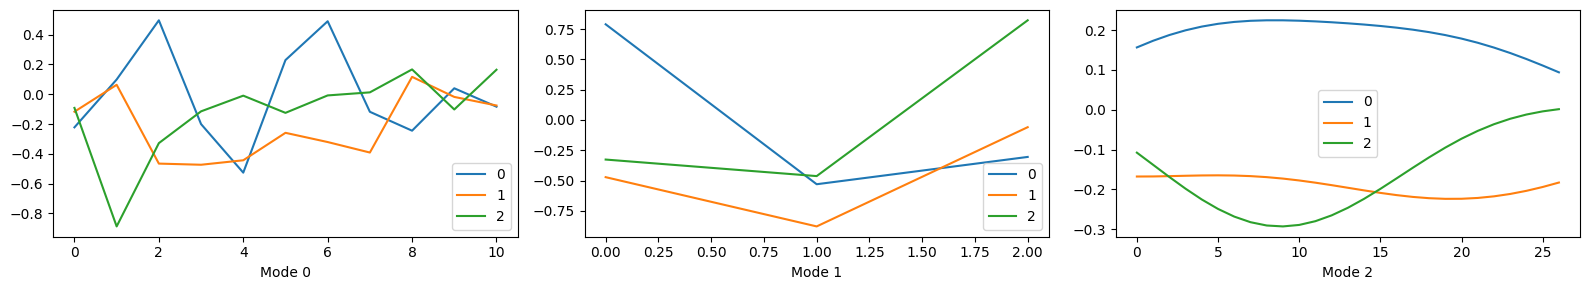

In [77]:
cp_tensor_postprocessed = tlviz.postprocessing.postprocess(cp_tensor, metric_weight_tensor)
fig, ax = tlviz.visualisation.components_plot(cp_tensor_postprocessed)
plt.show()

In [91]:
def fit_many_parafac(X, num_components, num_inits=5):
    return [
        parafac(
            X,
            num_components,
            n_iter_max=1000,
            tol=1e-8,
            init="random",
            orthogonalise=True,
            linesearch=True,
            random_state=i,
        )
        for i in range(num_inits)
    ]

In [101]:
models = {}
for rank in range(1,7):
    print(f"{rank} components")
    models[rank] = fit_many_parafac(metric_weight_tensor, rank, num_inits=5)

1 components
2 components
3 components
4 components
5 components
6 components


In [109]:
errors = {}
for rank, inits in models.items():
    sorted_inits, sorted_errors = tlviz.multimodel_evaluation.sort_models_by_error(inits, metric_weight_tensor)
    models[rank] = sorted_inits
    errors[rank] = sorted_errors

selected_models = {rank: inits[0] for rank, inits in models.items()}

In [103]:
fms_with_selected = {}
for rank, inits in models.items():
    fms_with_selected[rank] = tlviz.multimodel_evaluation.similarity_evaluation(inits[0], inits)

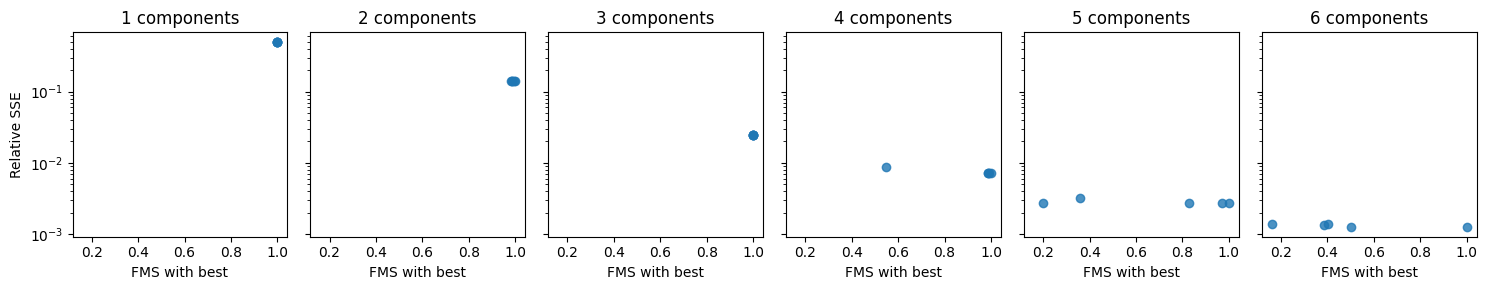

In [104]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), tight_layout=True, sharex=True, sharey=True)

for i, rank in enumerate(errors):
    axes[i].scatter(fms_with_selected[rank], errors[rank], alpha=0.8)
    axes[i].set_title(f"{rank} components")
    axes[i].set_xlabel("FMS with best")
    axes[i].set_yscale("log")

axes[0].set_ylabel("Relative SSE")
plt.show()

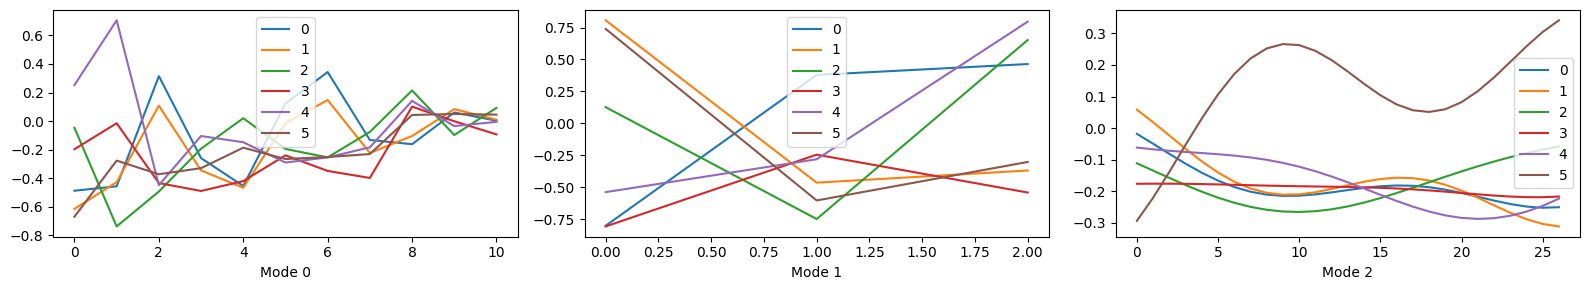

In [105]:
model_6comp = tlviz.postprocessing.postprocess(selected_models[6], dataset=metric_weight_tensor)
tlviz.visualisation.components_plot(model_6comp)
plt.show()

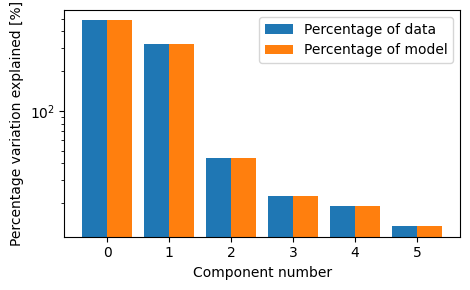

In [106]:
fig, ax = plt.subplots(figsize=(3 * 1.6, 3), tight_layout=True)
tlviz.visualisation.percentage_variation_plot(model_6comp, metric_weight_tensor, method="both", ax=ax)
ax.set_yscale("log")
plt.show()

In [107]:
predicted_curves = np.einsum("ij,ljk->ilk", covariate_X, metric_weight_tensor)

### Repeat With Predicted Curves

In [110]:
models = {}
for rank in range(1,7):
    print(f"{rank} components")
    models[rank] = fit_many_parafac(predicted_curves, rank, num_inits=5)

1 components
2 components
3 components
4 components
5 components
6 components


In [111]:
errors = {}
for rank, inits in models.items():
    sorted_inits, sorted_errors = tlviz.multimodel_evaluation.sort_models_by_error(inits, predicted_curves)
    models[rank] = sorted_inits
    errors[rank] = sorted_errors

selected_models = {rank: inits[0] for rank, inits in models.items()}

In [112]:
fms_with_selected = {}
for rank, inits in models.items():
    fms_with_selected[rank] = tlviz.multimodel_evaluation.similarity_evaluation(inits[0], inits)

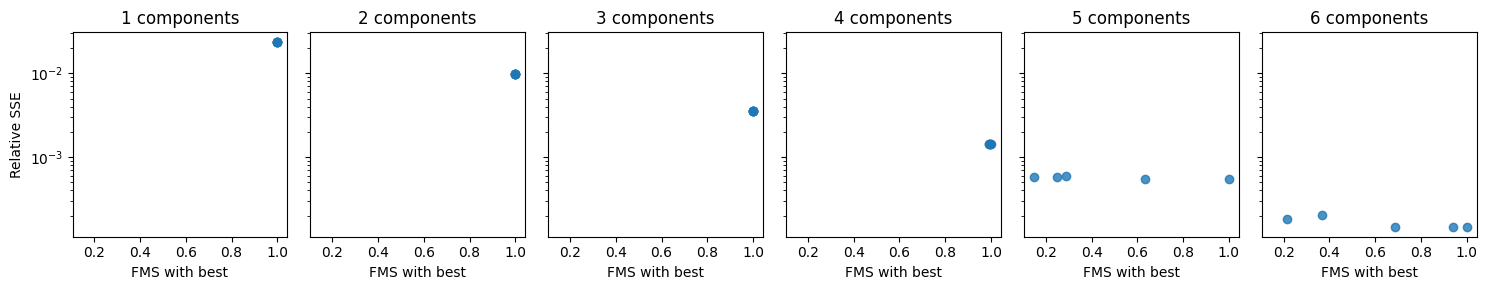

In [113]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), tight_layout=True, sharex=True, sharey=True)

for i, rank in enumerate(errors):
    axes[i].scatter(fms_with_selected[rank], errors[rank], alpha=0.8)
    axes[i].set_title(f"{rank} components")
    axes[i].set_xlabel("FMS with best")
    axes[i].set_yscale("log")

axes[0].set_ylabel("Relative SSE")
plt.show()

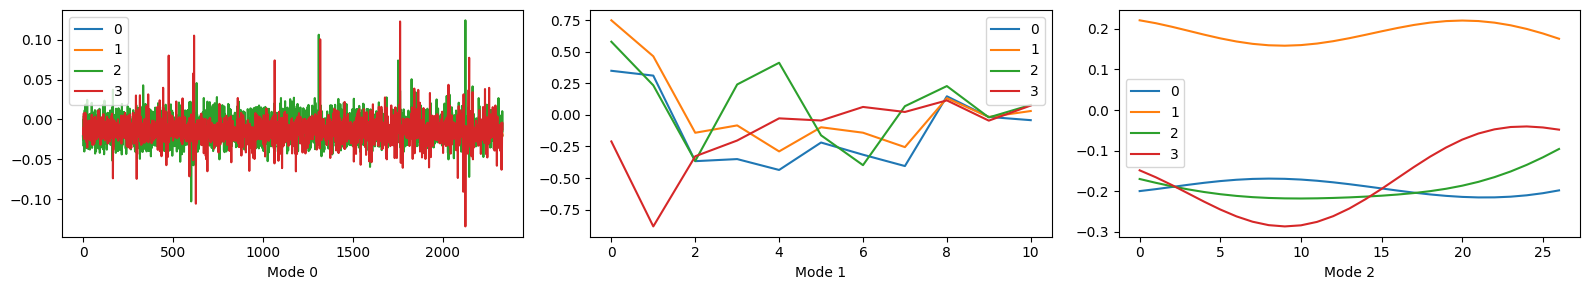

In [154]:
model_4comp = tlviz.postprocessing.postprocess(selected_models[4], dataset=predicted_curves)
tlviz.visualisation.components_plot(model_4comp)
plt.show()

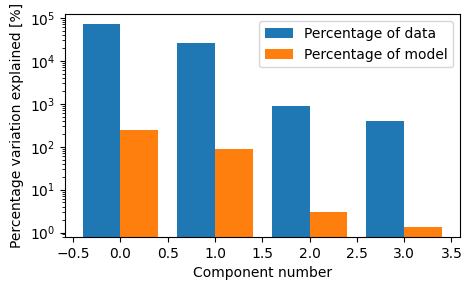

In [155]:
fig, ax = plt.subplots(figsize=(3 * 1.6, 3), tight_layout=True)
tlviz.visualisation.percentage_variation_plot(model_4comp, metric_weight_tensor, method="both", ax=ax)
ax.set_yscale("log")
plt.show()

In [118]:
data = data.sort_values(by=["id","year"])

In [119]:
name_mapper = data[["name", "id"]].drop_duplicates(ignore_index=True)

In [171]:
tensor_player_decomp = pd.DataFrame(model_4comp[1][0], columns=[f"player_component_{i}" for i in range(4)])

In [157]:
name_mapper

,name,id
0,Byron Scott,2
1,Grant Long,3
2,Dan Schayes,7
3,Sedale Threatt,9
4,Chris King,12
...,...,...
2327,Facundo Campazzo,1630267
2328,Nate Darling,1630268
2329,Brodric Thomas,1630271
2330,Freddie Gillespie,1630273


In [166]:
name_map = {index:name for index,name in enumerate(name_mapper["name"])}

In [172]:
tensor_player_decomp["name"] = name_mapper["name"]

### Nearest Neighbors

In [159]:
from sklearn.neighbors import NearestNeighbors

In [161]:
nn_obj = NearestNeighbors(n_neighbors=5).fit(tensor_player_decomp[[f"player_component_{i}" for i in range(4)]])

In [174]:
nearest = nn_obj.kneighbors(tensor_player_decomp[[f"player_component_{i}" for i in range(4)]], return_distance=False)

for i in range(1,5):
    tensor_player_decomp[f"nearest_player_{i}"] = [name_map[val] for val in nearest[:,i]]

In [228]:
tensor_player_decomp.query("name in ['Kawhi Leonard', 'Nikola Jokic','Giannis Antetokounmpo','LeBron James', 'Rudy Gobert', 'Kobe Bryant', 'Michael Jordan', 'Draymond Green', 'Kevin Durant', 'Steve Nash', 'James Harden', 'Klay Thompson', 'Ray Allen', 'Patrick Ewing', 'Tim Duncan', 'Dirk Nowitzki', 'Devin Booker', 'Luka Doncic']")[["name"] + [f"nearest_player_{i}" for i in range(1,5)]]

,name,nearest_player_1,nearest_player_2,nearest_player_3,nearest_player_4
65,Patrick Ewing,John Henson,Scot Pollard,Dewayne Dedmon,Michael Cage
328,Michael Jordan,Patrick Beverley,Grant Hill,Tracy McGrady,Kendall Gill
369,Ray Allen,Derrick Rose,Antonio Daniels,Reggie Miller,Mitch Richmond
377,Steve Nash,Deron Williams,Jose Calderon,Trae Young,Kendall Marshall
391,Kobe Bryant,Brent Barry,Steve Francis,Delonte West,Joe Ingles
481,Tim Duncan,Joel Embiid,Anthony Davis,Mason Plumlee,Kyle O'Quinn
563,Dirk Nowitzki,Blake Griffin,Matt Barnes,Rudy Gay,P.J. Tucker
890,LeBron James,LaMelo Ball,De'Anthony Melton,Manu Ginobili,Russell Westbrook
1193,Kevin Durant,Trevor Ariza,Tracy McGrady,Julyan Stone,Bonzi Wells
1299,Patrick Ewing,Craig Brackins,Richard Manning,Oliver Lafayette,Rawle Alkins


In [198]:
nn_pca = NearestNeighbors(n_neighbors=5).fit(covariate_X)

In [200]:
pca_decomp = pd.DataFrame(covariate_X, columns = [f"component_{i}" for i in range(covariate_X.shape[1])])

In [201]:
pca_decomp["name"] = name_mapper["name"]

In [202]:
nearest_pca = nn_pca.kneighbors(covariate_X, return_distance=False)

for i in range(1,5):
    pca_decomp[f"nearest_player_{i}"] = [name_map[val] for val in nearest_pca[:,i]]

In [227]:
pca_decomp.query("name in ['Kawhi Leonard', 'Nikola Jokic','Giannis Antetokounmpo', 'LeBron James', 'Rudy Gobert', 'Kobe Bryant', 'Michael Jordan', 'Draymond Green', 'Kevin Durant', 'Steve Nash', 'James Harden', 'Klay Thompson', 'Ray Allen', 'Patrick Ewing', 'Tim Duncan', 'Dirk Nowitzki', 'Devin Booker', 'Luka Doncic']")[["name"] + [f"nearest_player_{i}" for i in range(1,5)]]

,name,nearest_player_1,nearest_player_2,nearest_player_3,nearest_player_4
65,Patrick Ewing,Jeff Withey,Nic Claxton,John Henson,Anderson Varejao
328,Michael Jordan,Derrick White,Kerry Kittles,Toni Kukoc,Patrick Beverley
369,Ray Allen,Joe Johnson,Reggie Miller,Vince Carter,Damian Lillard
377,Steve Nash,Chauncey Billups,Jose Calderon,Deron Williams,Jason Terry
391,Kobe Bryant,Paul Pierce,Vince Carter,Jason Terry,Damian Lillard
481,Tim Duncan,Anthony Davis,Kevin Garnett,Karl-Anthony Towns,Dwight Howard
563,Dirk Nowitzki,Kevin Durant,Pau Gasol,LaMarcus Aldridge,Vince Carter
890,LeBron James,James Harden,Kevin Durant,Shamorie Ponds,Jason Kidd
1193,Kevin Durant,Paul Pierce,Vince Carter,Tracy McGrady,Kobe Bryant
1299,Patrick Ewing,Andreas Glyniadakis,Lou Roe,Craig Brackins,Britton Johnsen


In [229]:
metrics

['obpm',
 'dbpm',
 'blk',
 'stl',
 'ast',
 'dreb',
 'oreb',
 'tov',
 'ftm',
 'fg2m',
 'fg3m']

In [231]:
predicted_curves.shape

(2332, 11, 27)

In [263]:
def plot_metrics(curves, name_mapper, metric_list, name):
    for metric_index, metric in enumerate(metric_list):
        idx_player = name_mapper.index[name_mapper["name"] == name].tolist()[0]
        curve_to_plot = curves[idx_player,metric_index,:]
        plt.plot(curve_to_plot)
        plt.title(f"Metric: {metric}, Player: {name}")
        plt.show()


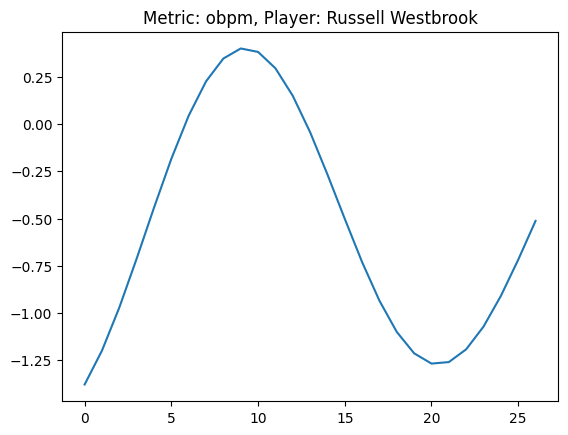

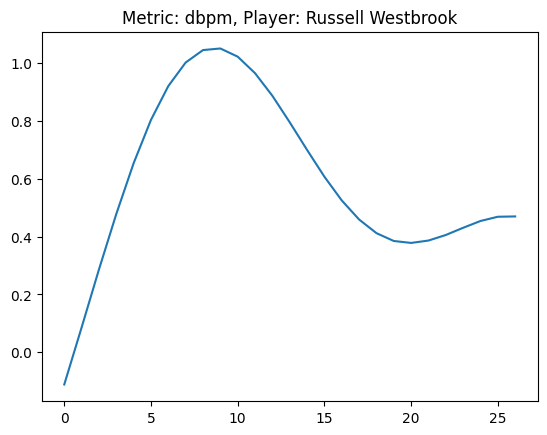

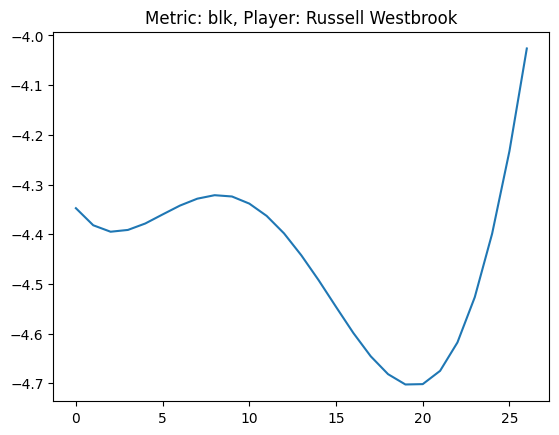

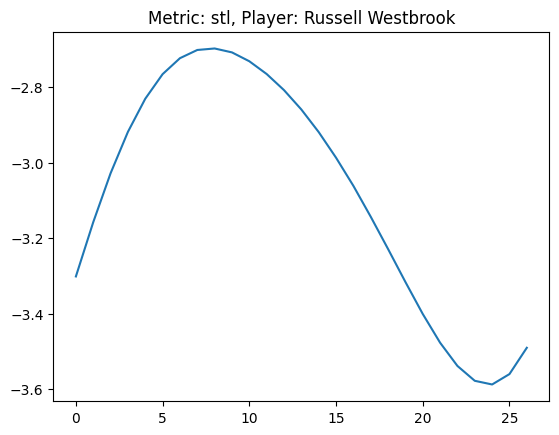

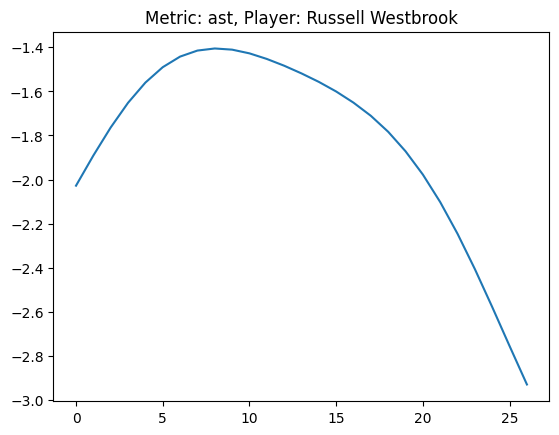

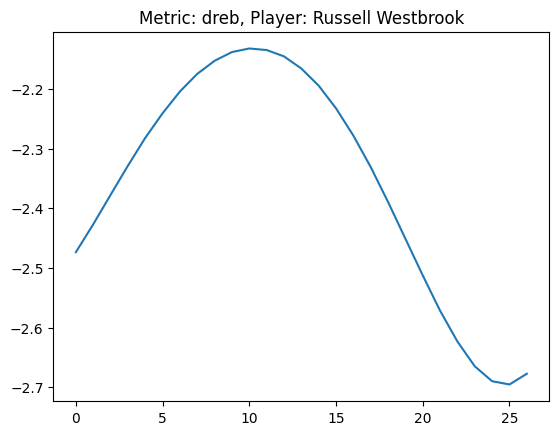

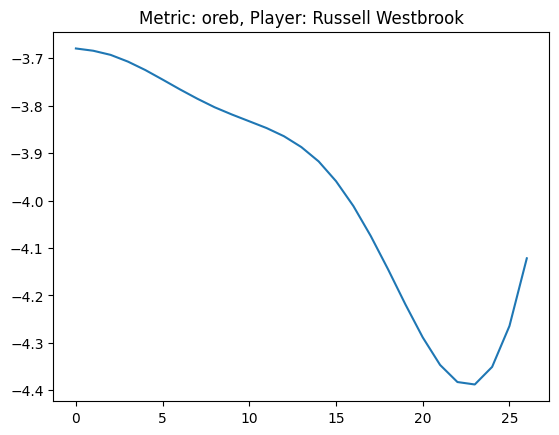

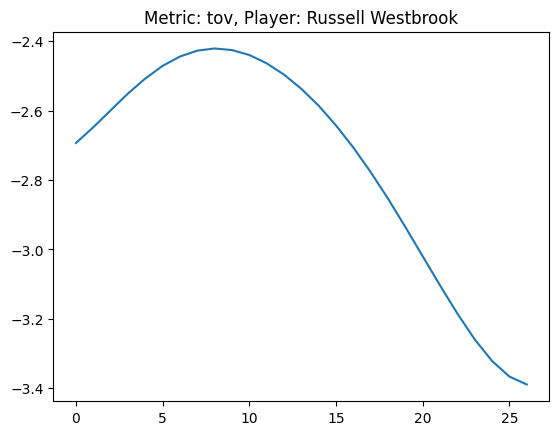

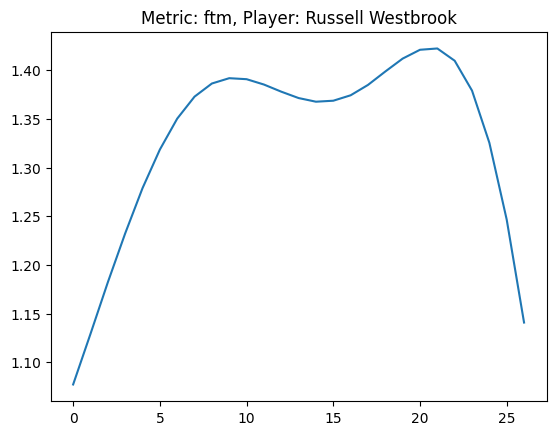

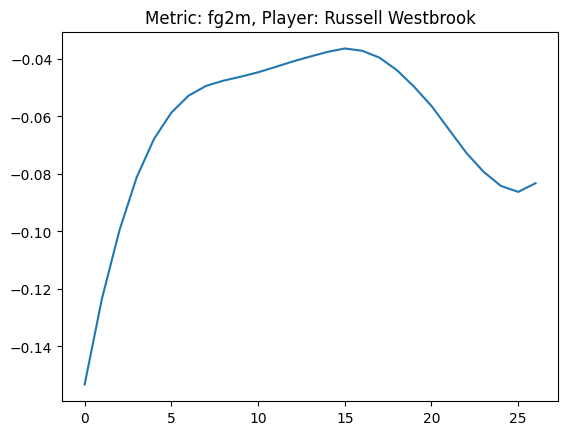

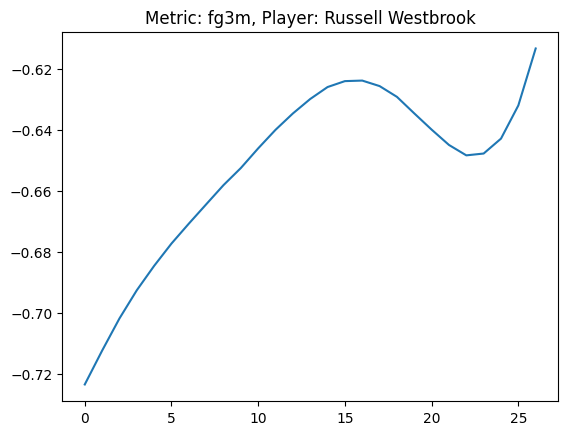

In [265]:
plot_metrics(predicted_curves, name_mapper, metrics, "Russell Westbrook")

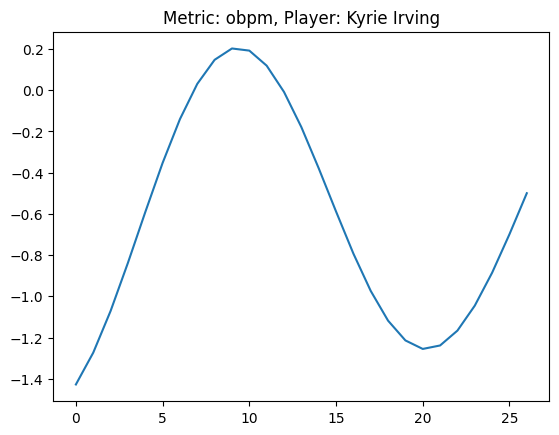

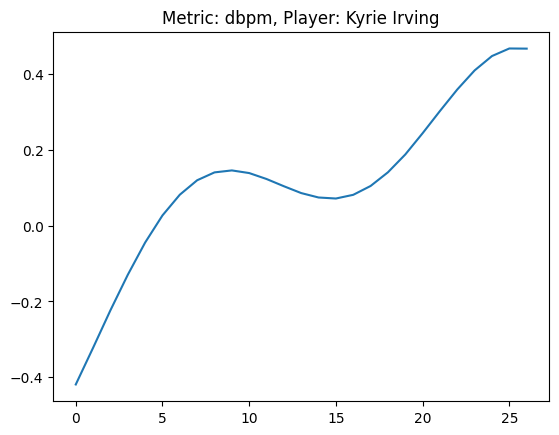

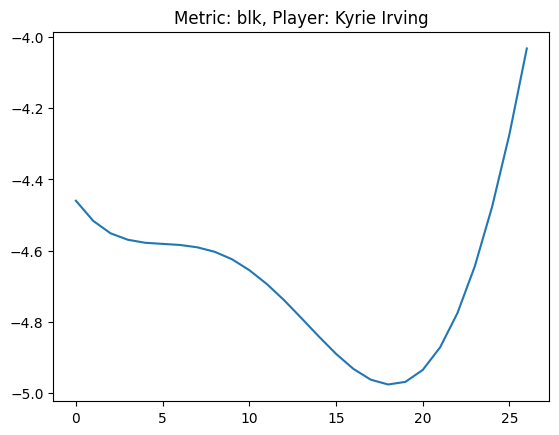

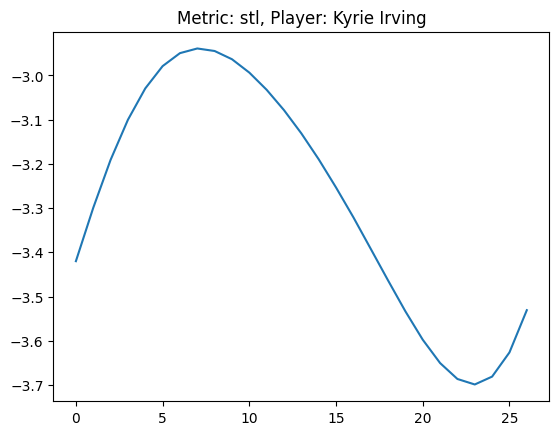

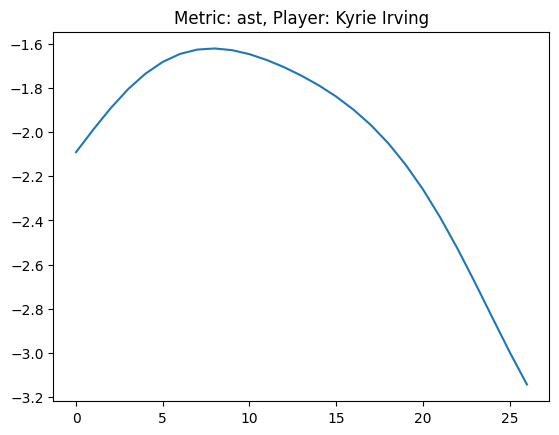

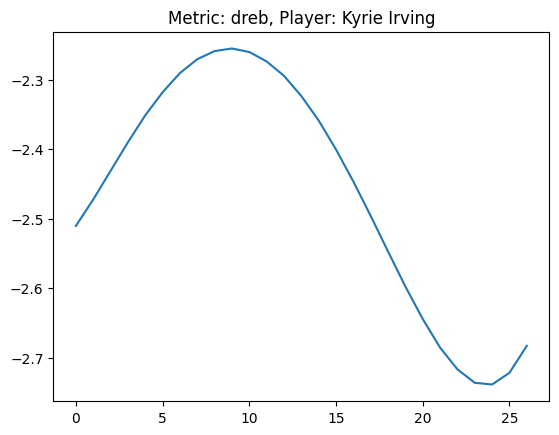

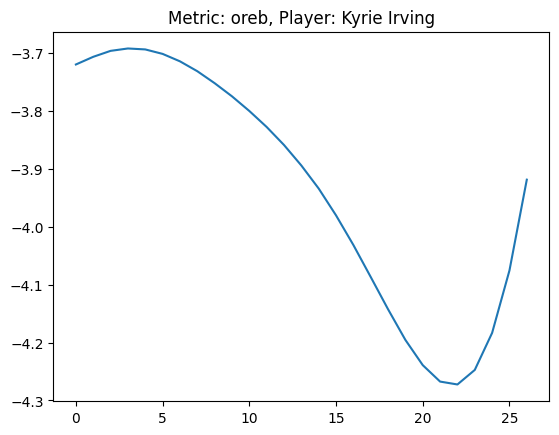

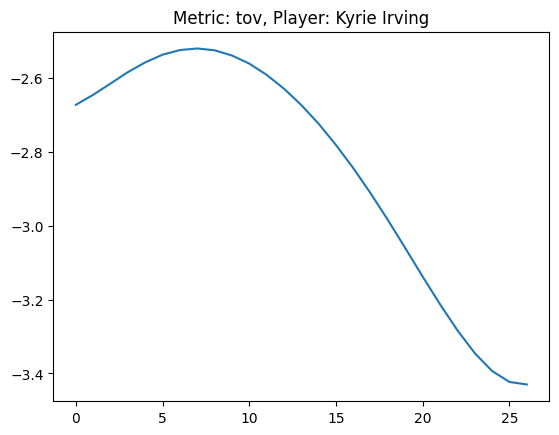

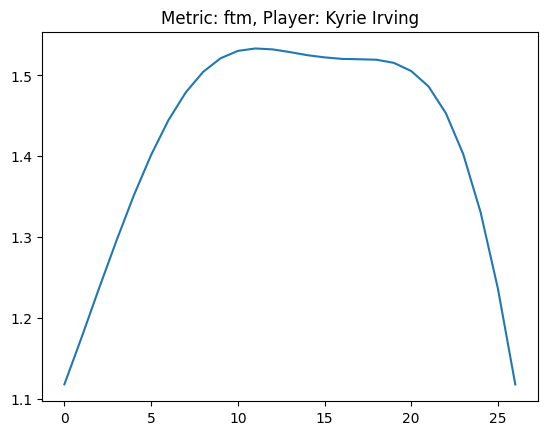

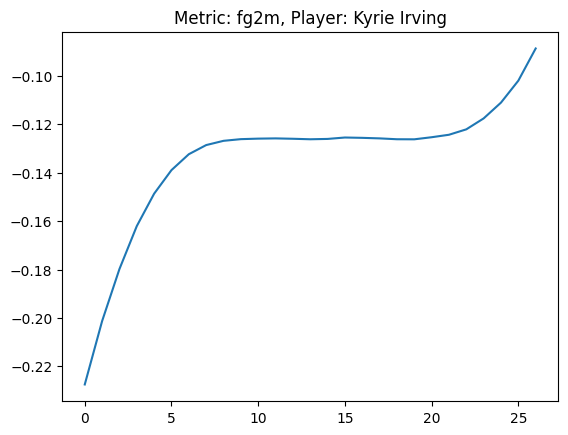

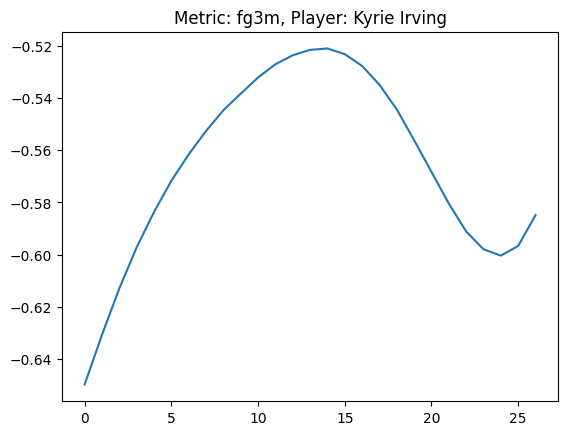

In [266]:
plot_metrics(predicted_curves, name_mapper, metrics, "Kyrie Irving")